In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
full_df = pd.read_csv('atp_transformed/2000-2024 players_2.csv')

C:\Users\Golbe\AppData\Local\Temp\ipykernel_508\2909268294.py:1: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('atp_transformed/2000-2024 players_2.csv')


In [ ]:
selected_features = ['surface', 
'tourney_level', 
#'tourney_date', dropped because not numeric 
'match_num', 
'player_seed', 
'player_height', 
'player_country', 
'player_age', 
'elo_pre_match', 
'opponent_elo_pre_match', 
#'opponent_rank', # dropped because of leakage 
'mean_numb', 
'median_numb', 
'total_numb', 
'mean_diff', 
'median_diff', 
'total_diff', 
'mean_tb_numb', 
'median_tb_numb', 
'total_tb_numb', 
'mean_tb_diff', 
'median_tb_diff', 
'total_tb_diff', 
'days_of_experience',
'career_year', 
'rest_days', 
'set_dominance', 
'tb_dominance', 
'highest_finish_position', 
'minutes_rolling_med_10', 
'draw_size_rolling_med_10', 
'highest_finish_position_rolling_med_10', 
'ace_rolling_mean_10', 
'double_faults_rolling_mean_10', 
'points_on_serve_rolling_mean_10', 
'first_serve_in_rolling_mean_10', 
'1stWon_rolling_mean_10', 
'2ndWon_rolling_mean_10', 
'service_games_rolling_mean_10', 
'break_points_saved_rolling_mean_10', 
'break_points_faced_rolling_mean_10', 
'elo_pre_match_rolling_mean_10', 
'opponent_elo_pre_match_rolling_mean_10', 
'set_dominance_rolling_mean_10', 
'tb_dominance_rolling_mean_10', 
#'player_rank_rolling_mean_10', # dropped because of leakage
'mean_numb_rolling_mean_10', 
'median_numb_rolling_mean_10', 
'total_numb_rolling_mean_10', 
'mean_diff_rolling_mean_10', 
'median_diff_rolling_mean_10', 
'total_diff_rolling_mean_10', 
'mean_tb_numb_rolling_mean_10', 
'median_tb_numb_rolling_mean_10', 
'total_tb_numb_rolling_mean_10', 
'mean_tb_diff_rolling_mean_10', 
'median_tb_diff_rolling_mean_10', 
'total_tb_diff_rolling_mean_10', 
'elo_next_match',
'player_rank_filled']

In [4]:
# replace missing elo scores with default starting value
full_df['elo_next_match'] = full_df['elo_next_match'].replace(np.nan,1500)
full_df['rolling_opponent_elo'] = full_df['opponent_elo_pre_match_rolling_mean_10'].replace(np.nan,1500) 
full_df['rolling_elo'] = full_df['elo_pre_match_rolling_mean_10'].replace(np.nan,1500)

In [5]:
# get subset
df_subset = full_df[selected_features]

# drop all values where nan
df_subset = df_subset.dropna()

In [6]:
# encode non numeric values
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
surface_encoded = encoder.fit_transform(df_subset[['surface','player_country','tourney_level']])
surface_df = pd.DataFrame(surface_encoded, 
                          columns=encoder.get_feature_names_out(['surface','player_country','tourney_level']),
                          index=df_subset.index)
df_encoded = pd.concat([df_subset.drop(['surface','player_country','tourney_level'], axis=1), surface_df], axis=1)

In [ ]:
# prepare data
X = df_encoded.drop('player_rank_filled', axis=1)  # Features
y = df_encoded['player_rank_filled']  # Target

In [8]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# scale features to normalise
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# train
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [11]:
# predict
y_pred = knn.predict(X_test_scaled)

In [12]:
# metrics
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

print(f"Min: {y.min()}")
print(f"Max: {y.max()}")
print(f"Range: {y.max() - y.min()}")
print(f"Mean: {y.mean()}")
print(f"Std: {y.std()}")

# Check if there's overfitting
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)
print(f"Train R²: {train_score:.4f}")
print(f"Test R²: {test_score:.4f}")

R² Score: 0.6496
Mean Absolute Error: 104.9155
Root Mean Squared Error: 141.7560
Min: 1312.4618519734915
Max: 2931.326867053432
Range: 1618.8650150799406
Mean: 1975.566120174863
Std: 242.81031646502544
Train R²: 0.7783
Test R²: 0.6496


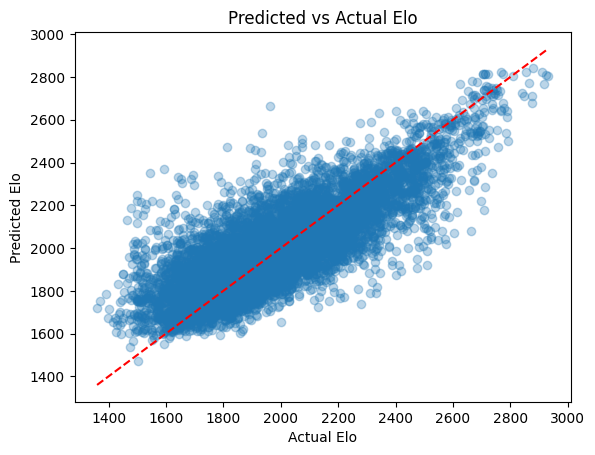

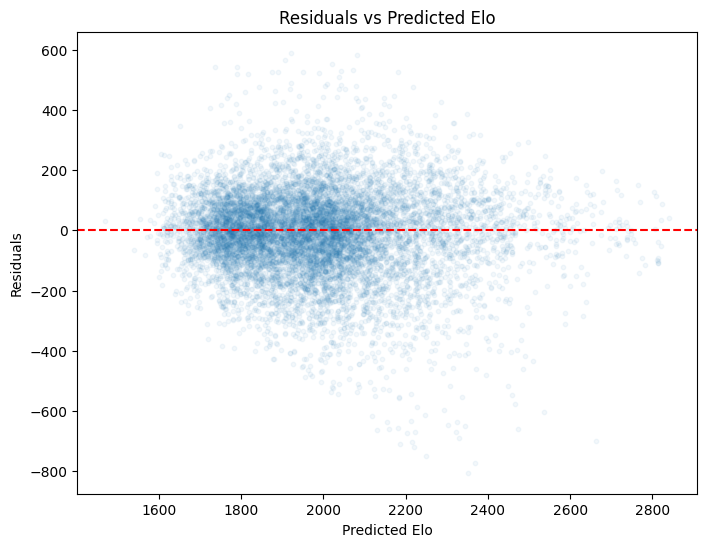

In [13]:
y_true = y_test

# Assuming y_true and y_pred are already numpy arrays
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual Elo')
plt.ylabel('Predicted Elo')
plt.title('Predicted vs Actual Elo')
plt.show()

# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.05, s=10)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Elo')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Elo')
plt.show()